### Load X


Generate text vectors using the comments. Each comment is also tagged with the listing_id it is associated with.

In [21]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
reviews = pd.read_csv('data/reviews.csv', usecols=['listing_id', 'id', 'comments'])

In [35]:
reviews.head()

,listing_id,id,comments
0,2515,198,Stephanie was a wonderful host! Her apartment ...
1,21456,29826,We had a delightful stay at Dana's fantastical...
2,21456,30680,"Dana's place is charming, and very well-locate..."
3,21456,32640,"great stay, i would recommend her anytime..."
4,21456,34234,Dana is a warm and welcoming host. We enjoyed...


In [36]:
# Remove NAs

reviews.dropna(inplace=True)

### Alternative X: English only reviews

Many reviews are in non-English languages which may impact model performance.  I will filter those out using `langdetect`.

In [98]:
def detect_lang(text):
    from langdetect import detect
    try:
        return detect(text)
    except:
        return "unknown"

In [99]:
reviews['lang'] = reviews.comments.apply(detect_lang)

In [104]:
reviews[reviews.lang=='en'].to_csv('reviews_eng.csv')

### Load y

Load latest price for each listing.

In [37]:
prices = pd.read_csv('price.csv')

In [38]:
prices.columns = ['listing_id', 'price']

In [39]:
prices.dtypes

listing_id      int64
price         float64
dtype: object

In [40]:
reviews_price = pd.merge(reviews, prices, how='left', on='listing_id').dropna()

In [41]:
reviews_price.head()

,listing_id,id,comments,price
0,2515,198,Stephanie was a wonderful host! Her apartment ...,59.0
1,21456,29826,We had a delightful stay at Dana's fantastical...,140.0
2,21456,30680,"Dana's place is charming, and very well-locate...",140.0
3,21456,32640,"great stay, i would recommend her anytime...",140.0
4,21456,34234,Dana is a warm and welcoming host. We enjoyed...,140.0


In [42]:
reviews_price.to_csv('reviews_price.csv', index=False)

### Load Alternative y

With only english reviews

In [109]:
reviews_eng = pd.read_csv('reviews_eng.csv')

In [111]:
reviews_eng.dtypes

id             int64
listing_id     int64
comments      object
lang          object
dtype: object

In [114]:
prices = pd.read_csv('price.csv')
prices.columns = ['listing_id', 'price']

In [115]:
reviews_price_alt = pd.merge(reviews_eng, prices, how='left', on='listing_id')

In [123]:
reviews_price_alt.drop(['lang'], axis=1).to_csv("reviews_price_alt.csv", index=False)

--------------------------------------------------------------------------------------------------

To save memory, do not run above code.  Instead, go straight to **Vectorizing text** and load X or alternative X as you like.

--------------------------------------------------------------------------------------------------

### Vectorizing text

Need to turn each review into an array with equal length.

First try vectorizing by word countTFIDF with skip-gram

Consider using custom tokenizer due to memory constraints - default tokenizers use a lot of memory, maybe because they are unable to filter words.  However, this flexibility could lead to slower code and/or inability to filter punctuations.  Custom tokenizer not optimized for speed.  Code is left here for future tweaks.

In [14]:
# from nltk import download
# from nltk.corpus import stopwords 
# download('stopwords')
# stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /home/twang/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
# def Tokenizer(str_input):
#     from re import sub
#     from nltk.stem.porter import PorterStemmer
#     from string import punctuation
    
#     # Remove punctuations
#     str_input = str_input.translate(None, punctuation)
    
#     # Remove any word containing a number (of which there are many)
#     words = sub(u'(?ui)\\b[a-zA-Z0-9]*[0-9]+[a-zA-Z0-9]*\\b', " ", str_input).lower().split()
    
#     porter_stemmer=PorterStemmer()
#     words = [porter_stemmer.stem(word) for word in words if not word in stop_words]
#     return words

In [43]:
import pandas as pd
import numpy as np
reviews_price = pd.read_csv('reviews_price.csv')

In [44]:
reviews_price.head()

,listing_id,id,comments,price
0,2515,198,Stephanie was a wonderful host! Her apartment ...,59.0
1,21456,29826,We had a delightful stay at Dana's fantastical...,140.0
2,21456,30680,"Dana's place is charming, and very well-locate...",140.0
3,21456,32640,"great stay, i would recommend her anytime...",140.0
4,21456,34234,Dana is a warm and welcoming host. We enjoyed...,140.0


In [46]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_price[['id', 'comments']], reviews_price.price, test_size = 0.2, \
                                                    random_state = 45)

In [62]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
pd.DataFrame(y_train, columns = ['price']).to_csv('y_train.csv')
pd.DataFrame(y_test, columns = ['price']).to_csv('y_test.csv')

In [63]:
class count_preprocessing:
    
    def __init__(self, svd_components = 50):
        # import pandas as pd
        # import numpy as np
        from sklearn.decomposition import TruncatedSVD
        from sklearn.feature_extraction.text import CountVectorizer
        from sklearn.pipeline import make_pipeline

        # Make instances
        ## Used a token pattern to use only words without numbers
        self.count = CountVectorizer(stop_words='english',\
                                     lowercase=True,\
                                     token_pattern=u'(?ui)\\b[a-zA-Z]*[a-zA-Z]+[a-zA-Z]*\\b',\
                                    min_df=0.025)
#         self.count = CountVectorizer(analyzer=Tokenizer, min_df = 0.1)
        self.svd = TruncatedSVD(n_components=svd_components)
        self.pipeline = make_pipeline(self.count, self.svd)

    def fit_transform(self, text_data):
        """
        Fits and transforms text data pandas series into matrix of svd_components columns
        Input:
            text_data: column or series of text data
        Output:
            A matrix with same number of rows as input and svd_components columns
        """
        return(self.pipeline.fit_transform(text_data))
        
    def transform(self, text_data):
        """
        Transforms new data into the right format
        Input:
            text_data: column or series of text data (for testing most likely)
        Output:
            A matrix with same number of rows as input and svd_components columns
        """
        return(self.pipeline.transform(text_data))

In [65]:
%%time

count_prep = count_preprocessing()

count_train = count_prep.fit_transform(X_train.comments)
count_test = count_prep.transform(X_test.comments)

CPU times: user 1min 4s, sys: 3.35 s, total: 1min 7s
Wall time: 44.8 s


In [76]:
count_prep.count.get_feature_names()

['access',
 'accommodating',
 'airbnb',
 'amazing',
 'amenities',
 'apartment',
 'appartement',
 'area',
 'arrival',
 'arrived',
 'available',
 'away',
 'awesome',
 'bars',
 'bathroom',
 'beautiful',
 'bed',
 'bedroom',
 'best',
 'better',
 'bien',
 'big',
 'bit',
 'blocks',
 'brooklyn',
 'building',
 'central',
 'check',
 'city',
 'clean',
 'close',
 'coffee',
 'come',
 'comfortable',
 'comfy',
 'communication',
 'convenient',
 'cool',
 'cozy',
 'd',
 'day',
 'days',
 'definitely',
 'described',
 'did',
 'didn',
 'distance',
 'easy',
 'en',
 'enjoyed',
 'es',
 'est',
 'et',
 'exactly',
 'excellent',
 'experience',
 'extremely',
 'family',
 'fantastic',
 'feel',
 'felt',
 'food',
 'friendly',
 'gave',
 'good',
 'got',
 'great',
 'help',
 'helpful',
 'highly',
 'home',
 'host',
 'hosts',
 'house',
 'just',
 'kind',
 'kitchen',
 'l',
 'la',
 'late',
 'like',
 'little',
 'living',
 'local',
 'located',
 'location',
 'looking',
 'lot',
 'lots',
 'loved',
 'lovely',
 'make',
 'manhattan',
 

After using only high-prequency words (by setting min_df to 0.05) we can see that the features make a lot of sense.  One down side is that there is no good way to stem the words.  For that we will have to use the custom tokenizer which may be much slower.

In [77]:
pd.DataFrame(count_train, index=X_train.index).to_csv('count_train.csv', index=True)

In [78]:
pd.DataFrame(count_test, index=X_test.index).to_csv('count_test.csv', index=True)

Slightly more sophisticated vectorization: TFIDF with skip-gram

In [79]:
class tfidf_preprocessing:
    
    def __init__(self, svd_components = 50):
        # import pandas as pd
        # import numpy as np
        from sklearn.decomposition import TruncatedSVD
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.pipeline import make_pipeline

        # Make instances
        ## Used a token pattern to use only words without numbers
        self.tfidf = TfidfVectorizer(stop_words='english', lowercase=True, \
                                     token_pattern=u'(?ui)\\b[a-zA-Z]*[a-zA-Z]+[a-zA-Z]*\\b', \
                                     max_df=0.9, \
                                     min_df=0.025,\
                                     ngram_range=(1,2))
        self.svd = TruncatedSVD(n_components=svd_components)
        self.pipeline = make_pipeline(self.tfidf, self.svd)

    def fit_transform(self, text_data):
        """
        Fits and transforms text data pandas series into matrix of svd_components columns
        Input:
            text_data: column or series of text data
        Output:
            A matrix with same number of rows as input and svd_components columns
        """
        return(self.pipeline.fit_transform(text_data))
        
    def transform(self, text_data):
        """
        Transforms new data into the right format
        Input:
            text_data: column or series of text data (for testing most likely)
        Output:
            A matrix with same number of rows as input and svd_components columns
        """
        return(self.pipeline.transform(text_data))

In [80]:
%%time

tfidf_prep = tfidf_preprocessing()

tfidf_train = tfidf_prep.fit_transform(X_train.comments)
tfidf_test = tfidf_prep.transform(X_test.comments)

CPU times: user 1min 35s, sys: 4.04 s, total: 1min 39s
Wall time: 1min 16s


In [81]:
tfidf_prep.tfidf.get_feature_names()

['access',
 'accommodating',
 'airbnb',
 'amazing',
 'amenities',
 'apartment',
 'apartment clean',
 'appartement',
 'area',
 'arrival',
 'arrived',
 'available',
 'away',
 'awesome',
 'bars',
 'bathroom',
 'beautiful',
 'bed',
 'bedroom',
 'best',
 'better',
 'bien',
 'big',
 'bit',
 'blocks',
 'brooklyn',
 'building',
 'central',
 'central park',
 'check',
 'city',
 'clean',
 'clean comfortable',
 'close',
 'close subway',
 'coffee',
 'come',
 'comfortable',
 'comfy',
 'communication',
 'convenient',
 'cool',
 'cozy',
 'd',
 'day',
 'days',
 'definitely',
 'definitely recommend',
 'definitely stay',
 'described',
 'did',
 'didn',
 'didn t',
 'distance',
 'easy',
 'en',
 'enjoyed',
 'enjoyed stay',
 'es',
 'est',
 'et',
 'exactly',
 'excellent',
 'experience',
 'extremely',
 'family',
 'fantastic',
 'feel',
 'felt',
 'food',
 'friendly',
 'gave',
 'good',
 'got',
 'great',
 'great host',
 'great location',
 'great place',
 'great stay',
 'help',
 'helpful',
 'highly',
 'highly recomme

In [82]:
%%time
pd.DataFrame(tfidf_train, index=X_train.index).to_csv('tfidf_train.csv', index=True)
pd.DataFrame(tfidf_test, index=X_test.index).to_csv('tfidf_test.csv', index=True)

CPU times: user 48.2 s, sys: 935 ms, total: 49.2 s
Wall time: 49.3 s


### Topic Modeling

Best accomplished using tfidf vectors - more in-context meaning is preserved.  Will explore a few clustering techniques.

In [1]:
# Load Data
import numpy as np
import pandas as pd

tfidf_train = pd.read_csv('tfidf_train.csv', index_col=0)
tfidf_test = pd.read_csv('tfidf_test.csv', index_col=0)

In [2]:
from sklearn.cluster import KMeans

In [11]:
def cluster(array, random_state, n_clusters=4):
    '''
    Fits and predicts k-means clustering on "array"
    
    Parameters
    ----------
    array: A numpy array
    random_state: Random seed, e.g. check_random_state(0)
    n_clusters: The number of clusters. Default: 4
    
    Returns
    -------
    A tuple (sklearn.KMeans, np.ndarray)
    '''
    from sklearn.cluster import KMeans
    model = KMeans(n_clusters=n_clusters, random_state = random_state)
    model.fit(array)
    clusters = model.predict(array)
    
    return model, clusters

#here we return fitted (model) and predicted (clusters) arrays as a tuple

In [12]:
def plot_inertia(array, start=1, end=10):
    '''
    Increase the number of clusters from "start" to "end" (inclusive).
    Finds the inertia of k-means clustering for different k.
    Plots inertia as a function of the number of clusters.

    
    Parameters
    ----------
    array: A numpy array.
    start: An int. Default: 1
    end: An int. Default: 10
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    from sklearn.utils import check_random_state
    
    inertia = []
    for i in range(start, end+1):
        model, clusters = cluster(array, check_random_state(0), i)
        inertia.append(model.inertia_)
    
    x_axis = list(range(start, end+1))
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.set_title('The elbow method')
    ax.set_ylabel('Inertia')
    ax.set_xlabel('Number of clusters')
    plt.plot(x_axis, inertia)
    

    return ax

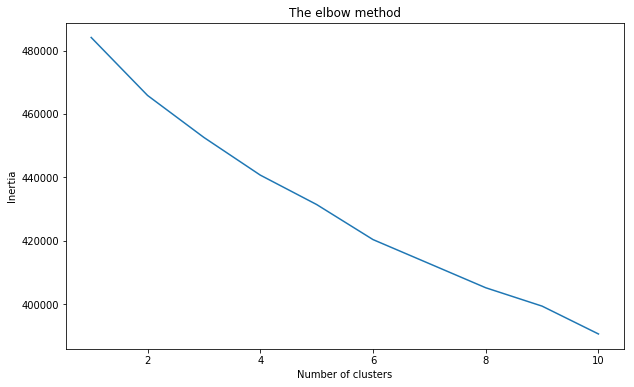

In [53]:
# Using elbow method to determine how many topics to have
plot_inertia(tfidf_train)

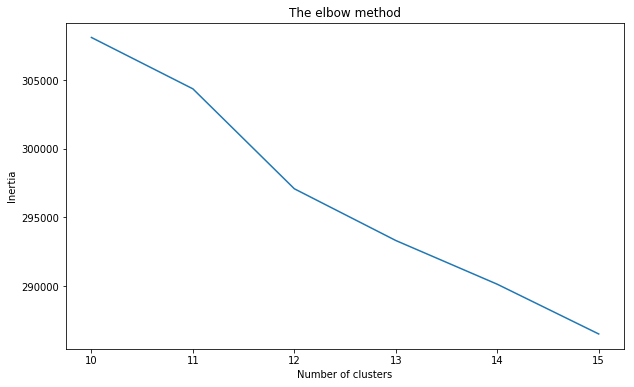

In [86]:
plot_inertia(tfidf_train, start=10, end=15)

In [87]:
# Don't really see any pattern - will go with a middle value
kmeans = KMeans(n_clusters=6)
kmeans.fit(tfidf_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [91]:
topic_labels = pd.DataFrame(kmeans.labels_, columns=['kmeans_label'], index=X_train.index)

In [92]:
topic_labels.kmeans_label.value_counts()

4    423786
0    192598
5    116809
2     62291
3     58690
1     14170
Name: kmeans_label, dtype: int64

In [93]:
topic_labels_test = pd.DataFrame(kmeans.predict(tfidf_test), columns=['kmeans_label'], index=X_test.index)

In [15]:
topic_labels_test[0].value_counts()

0    66117
2    41340
1    36539
3    17618
4    15749
5    13484
Name: 0, dtype: int64

Will sample a few reviews and see if the topics make sense.

In [94]:
from random import sample
sample_train = sample(range(X_train.shape[0]), 60)
sample_test = sample(range(X_test.shape[0]), 30)

In [98]:
pd.concat([X_train.iloc[sample_train], topic_labels.iloc[sample_train]], axis=1).sort_values('kmeans_label')

,id,comments,kmeans_label
386843,335624220,This is a wonderful place to stay in NYC. The ...,0
270995,51686662,The place was lovely and not to far from the S...,0
39880,1073100,Just got back to Florida.That was an awesome w...,0
795849,147792903,Host is absolutely welcoming. Even waited for ...,0
679758,297270988,"very clean,very safe place.",0
604148,284966503,I throughly enjoyed my stay at Aswad’s place! ...,0
672965,331808704,Lovely place in a great neighborhood,0
769955,217952632,The best place ever in NY and well located,0
193407,230928581,"Very nice place, good location, very nice host...",0
504530,109926298,the place is great and the host is very accomm...,0


In [99]:
pd.concat([X_test.iloc[sample_test], topic_labels_test.iloc[sample_test]], axis=1).sort_values('kmeans_label')

,id,comments,kmeans_label
479815,104595957,John's place is exactly as pictured. Definitel...,0
218906,273599924,Great place. Convenient to everything we need...,0
891280,210646364,"As a world citizen living in the Caribbean, it...",0
614198,99675286,"Great place, cozy and neat appartment in a ver...",0
322931,324722195,"Jeannie’s apartment is cosy, comfortable, clea...",0
724828,147387347,"Even with rain, David's place is light and bri...",0
221426,148818147,Appartement bien placé dans Harlem (compter 30...,2
599,174640527,Mizi ha sido muy buena anfitriona desde el pri...,2
342360,29275001,"Buena situación del apartamento, buen anfitrió...",3
548185,107435378,Elizabeth was a great host! She was able to ac...,3


Honestly I think this clustering works because it separates out foreign language reviews (cluster 2) as well as a cluster for negative reviews (cluster 1).  I think this encodes some information and would add to the model.

In [102]:
pd.concat([topic_labels, topic_labels_test], axis=0).to_csv('kmeans_topics.csv', index=True)

DBSCAN kernel died (maybe too many rows) so not gonna use this technique.

In [61]:
# from sklearn.cluster import DBSCAN
# dbsc = DBSCAN(eps = 0.5, min_samples = 1000)
# dbsc.fit(tfidf_train)